### Multi-Factor Crypto Allocation Strategy
This notebook implements a long-only allocation strategy for the top 10 cryptocurrencies, where position sizes are determined by averaging several normalized signals: momentum, days since high, price-to-SMA, and risk-reward potential. The strategy invests only when the combined signal is positive, scaling daily exposure to each asset accordingly, and compares performance against a scaled buy-and-hold benchmark using standard risk and return metrics.


In [1]:
# Imports & Parameters
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Date range for data
START_DATE = '2020-01-01'
END_DATE = '2026-06-01'

# Top 10 Crypto Tickers by Market Cap
TICKERS = ['BTC-USD', 'ETH-USD', 'XRP-USD', 'BNB-USD', 'SOL-USD', 'TRX-USD', 'ADA-USD', 'DOGE-USD', 'ZEC-USD', 'LINK-USD']

# Strategy parameters
MOMENTUM_WINDOW_MOMENTUM = 20
MOMENTUM_WINDOW_ZSCORE = 60

DSH_DAYS = 20
DSH_NORMALIZATION_GAMMA = 2
DSH_SOFTMAX_BETA = 10
DSH_SOFTMAX_WEIGHT_CUTTOFF = 0
DSH_EXPOSURE_AMPLIFIER = 4

PSMA_WINDOW_SMA = 30
PSMA_WINDOW_VOL = 30

RRP_WINDOW = 15
RRP_TANH_SCALING = 1
RRP_RETURN_AMPLIFICATION = 3

RANGE_WINDOW_RANGE = 20
RANGE_RANGE_AMPLIFIER = 1.5


In [2]:
# Data Downloading and Basic Features

# Download data
data = yf.download(TICKERS, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)

# Returns
returns = data['Close'].pct_change(fill_method=None)
returns.columns = pd.MultiIndex.from_product([['Returns'], returns.columns])

# Log Returns
log_returns = np.log(data['Close'] / data['Close'].shift(1))
log_returns.columns = pd.MultiIndex.from_product([['LogReturns'], log_returns.columns])

# Next day returns (shifted returns)
next_day_returns = returns.shift(-1)
next_day_returns.columns = pd.MultiIndex.from_product([['NextDayReturns'], returns.columns.get_level_values(1)])

In [3]:
# Feature Engineering

# Momentum Features
def calculate_momentum_features(close_prices, tickers, window_momentum, window_zscore):
    """
    Calculate momentum-based features for the trading strategy.
    
    Parameters:
    - close_prices: DataFrame of close prices
    - tickers: List of ticker symbols
    - window_momentum: Window size for momentum calculation
    - window_zscore: Window size for z-score calculation
    
    Returns:
    - momentum: Momentum values
    - momentum_zscore: Z-score of momentum
    - momentum_zscore_tanh: Tanh-transformed z-score of momentum
    """
    # Momentum (cumulative return over past window_momentum days)
    momentum = close_prices.pct_change(periods=window_momentum, fill_method=None)
    momentum.columns = pd.MultiIndex.from_product([['Momentum'], momentum.columns])
    
    # Z-score of momentum
    momentum_mean = momentum['Momentum'].rolling(window=window_zscore).mean()
    momentum_std = momentum['Momentum'].rolling(window=window_zscore).std()
    momentum_zscore = (momentum['Momentum'] - momentum_mean) / momentum_std
    momentum_zscore.columns = pd.MultiIndex.from_product([['MomentumZScore'], tickers])
    
    # Apply tanh transformation to momentum_zscore
    momentum_zscore_tanh = np.tanh(momentum_zscore['MomentumZScore'])
    momentum_zscore_tanh.columns = pd.MultiIndex.from_product([['MomentumZScoreTanh'], tickers])
    
    return momentum_zscore_tanh

# Days Since High Features
def calculate_dsh_features(data, tickers, dsh_days, normalization_gamma):
    """
    Calculate normalized days since high for given tickers.
    
    Parameters:
    -----------
    data : DataFrame
        Price data with 'Close' column
    tickers : list
        List of ticker symbols
    dsh_days : int
        Rolling window size for calculating days since high
    normalization_gamma : float
        Exponent for normalization formula
    
    Returns:
    --------
    tuple : (days_since_high, normalized_days_since_high)
        Two DataFrames with MultiIndex columns
    """
    # Initialize DataFrame for days since high
    days_since_high = pd.DataFrame(index=data.index, columns=tickers)

    # Calculate days since high for each ticker
    for ticker in tickers:
        close_prices = data['Close'][ticker]
        dsh = []

        for i in range(len(close_prices)):
            # Need at least DSH_DAYS to compute DSH
            if i < dsh_days:
                dsh.append(np.nan)
                continue
            
            # Get the past DSH_DAYS days (including current day)
            window = close_prices.iloc[i - dsh_days + 1 : i + 1]

            # Check if window has any non-NA values
            if window.isna().all():
                dsh.append(np.nan)
                continue
            
            # Find the index of the maximum closing price in the window
            max_index = window.idxmax()

            # Calculate days since high
            days_since = (close_prices.index[i] - max_index).days
            dsh.append(days_since)

        days_since_high[ticker] = dsh

    # Convert to MultiIndex columns
    days_since_high.columns = pd.MultiIndex.from_product([['DaysSinceHigh'], tickers])

    # Normalize using exponential shaping: u_i,t = (1 - DSH_i,t / (DSH_DAYS-1))^NORMALIZATION_GAMMA
    normalized_days_since_high = pd.DataFrame(index=days_since_high.index)

    for ticker in tickers:
        dsh_values = days_since_high[('DaysSinceHigh', ticker)]
        
        # Apply normalization formula
        normalized_values = (1 - dsh_values / (dsh_days - 1)) ** normalization_gamma
        
        # Clip negative values to 0 (in case DSH > dsh_days-1)
        normalized_values = normalized_values.clip(lower=0)
        
        normalized_days_since_high[ticker] = normalized_values

    # Convert to MultiIndex columns
    normalized_days_since_high.columns = pd.MultiIndex.from_product([['NormalizedDaysSinceHigh'], tickers])
    
    return normalized_days_since_high

# PSMA Features
def calculate_psma_features(close_prices, tickers, window_sma, window_vol):
    """
    Calculate strategy features including SMA, volatility-normalized PSMA, and bounded PSMA.
    
    Parameters:
    -----------
    close_prices : pd.DataFrame
        DataFrame containing close prices
    tickers : list
        List of ticker symbols
    window_sma : int
        Window size for simple moving average
    window_vol : int
        Window size for volatility calculation
    
    Returns:
    --------
    tuple : (sma, normalized_psma, normalized_psma_tanh)
    """
    # Simple Moving Average
    sma = close_prices.rolling(window=window_sma).mean()
    sma.columns = pd.MultiIndex.from_product([['SMA'], sma.columns])
    
    # Volatility-normalized PSMA
    log_psma = np.log(close_prices / sma['SMA'])
    volatility_psma = log_psma.rolling(window=window_vol).std()
    normalized_psma = log_psma / volatility_psma
    normalized_psma.columns = pd.MultiIndex.from_product([['NormalizedPSMA'], normalized_psma.columns])
    
    # Bound normalized_psma using tanh
    normalized_psma_tanh = np.tanh(normalized_psma)
    normalized_psma_tanh.columns = pd.MultiIndex.from_product([['NormalizedPSMATanh'], tickers])
    
    return normalized_psma_tanh

# Range Features
def calculate_range_features(data, window_range, range_amplifier, tickers):
    """
    Calculate raw range and bounded range signals for momentum strategy.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Multi-index DataFrame with price data (must contain 'Close' column)
    window_range : int
        Lookback window for calculating rolling min/max
    range_amplifier : float
        Amplification factor applied before clipping
    tickers : list
        List of ticker symbols
        
    Returns:
    --------
    tuple of (raw_range, raw_range_bounded)
        raw_range : pd.DataFrame with MultiIndex columns [('RawRange', ticker)]
        raw_range_bounded : pd.DataFrame with MultiIndex columns [('RawRangeBounded', ticker)]
    """
    # Raw Range (R_i,t) = (max - min) / current_price over lookback window
    rolling_max = data['Close'].rolling(window=window_range).max()
    rolling_min = data['Close'].rolling(window=window_range).min()
    raw_range = (rolling_max - rolling_min) / data['Close']
    raw_range.columns = pd.MultiIndex.from_product([['RawRange'], raw_range.columns])
    
    # Bounded signal using fixed limit
    raw_range_bounded = (raw_range * range_amplifier).clip(upper=1)
    raw_range_bounded.columns = pd.MultiIndex.from_product([['RawRangeBounded'], tickers])
    
    return raw_range_bounded

# RRP Features
def calculate_rrp_features(log_returns, window, tanh_scaling, return_amplification):
    """
    Calculate normalized RRP (Risk-Reward-Potential) using tanh scaling.
    
    Parameters:
    -----------
    log_returns : pd.DataFrame
        DataFrame containing log returns with MultiIndex columns
    window : int
        Rolling window size for calculating mean and std
    tanh_scaling : float
        Scaling factor for tanh function
    return_amplification : float
        Amplification factor for returns
    
    Returns:
    --------
    pd.DataFrame
        Normalized RRP values bounded between -1 and 1
    """
    # Calculate rolling mean return (μ_i,t)
    rolling_mean = log_returns.rolling(window=window).mean()
    
    # Calculate rolling standard deviation (σ_i,t)
    rolling_std = log_returns.rolling(window=window).std()
    
    # Extract values from MultiIndex structure for division
    rolling_mean_values = rolling_mean.droplevel(0, axis=1)
    rolling_std_values = rolling_std.droplevel(0, axis=1)
    
    # Calculate Raw RRP (Risk-Reward-Potential): μ_i,t / σ_i,t
    raw_rrp = rolling_mean_values / rolling_std_values
    
    # Normalize RRP using tanh scaling
    # This bounds the signal between -1 and 1
    normalized_rrp_tanh = np.tanh(tanh_scaling * raw_rrp * return_amplification)
    normalized_rrp_tanh.columns = pd.MultiIndex.from_product([['NormalizedRRPTanh'], TICKERS])
    
    return normalized_rrp_tanh

momentum = calculate_momentum_features(
    data['Close'], TICKERS, MOMENTUM_WINDOW_MOMENTUM, MOMENTUM_WINDOW_ZSCORE
)

dsh = calculate_dsh_features(
    data, TICKERS, DSH_DAYS, DSH_NORMALIZATION_GAMMA
)

psma = calculate_psma_features(
    data['Close'], TICKERS, PSMA_WINDOW_SMA, PSMA_WINDOW_VOL
)

range = calculate_range_features(
    data, RANGE_WINDOW_RANGE, RANGE_RANGE_AMPLIFIER, TICKERS
)

rrp = calculate_rrp_features(log_returns, RRP_WINDOW, RRP_TANH_SCALING, RRP_RETURN_AMPLIFICATION)

In [4]:
# Cross-Sectional Softmax Weights

def cross_sectional_softmax(signal_df, exposure_amplifier=1.0, weight_cutoff=0.01, beta=1.0):
    """
    Apply cross-sectional softmax per date.

    Parameters:
    - signal_df: DataFrame (Date x Tickers)
    - beta: aggressiveness parameter

    Returns:
    - weights_df: DataFrame of weights summing to 1 per date
    """
    exp_signal = np.exp(beta * signal_df)
    weights = exp_signal.div(exp_signal.sum(axis=1), axis=0)
    weights = weights * exposure_amplifier
    
    # Set weights to 0 if less than 0.01
    weights[weights < weight_cutoff] = 0
    
    # Renormalize so that remaining weights sum to exposure_amplifier
    weights = weights.div(weights.sum(axis=1), axis=0) * exposure_amplifier
    
    return weights

dsh_cs_weights = cross_sectional_softmax(
    dsh,
    exposure_amplifier=DSH_EXPOSURE_AMPLIFIER,
    weight_cutoff=DSH_SOFTMAX_WEIGHT_CUTTOFF,
    beta=DSH_SOFTMAX_BETA
)

In [5]:
# Combine Features

# Stack all features: momentum, dsh, psma, range, rrp
combined_signal = pd.DataFrame()

for ticker in TICKERS:
    # Extract each feature for this ticker and average them
    features_to_average = [
        momentum[('MomentumZScoreTanh', ticker)],
        dsh[('NormalizedDaysSinceHigh', ticker)],
        #dsh_cs_weights[('NormalizedDaysSinceHigh', ticker)],
        psma[('NormalizedPSMATanh', ticker)],
        #range[('RawRangeBounded', ticker)],
        rrp[('NormalizedRRPTanh', ticker)]
    ]
    
    # Combine into a temporary DataFrame and calculate mean across columns
    temp_df = pd.concat(features_to_average, axis=1)
    combined_signal[ticker] = temp_df.mean(axis=1)

# Add MultiIndex columns to match the format used elsewhere
combined_signal.columns = pd.MultiIndex.from_product([['CombinedSignal'], TICKERS])
combined_signal.to_pickle("combined_signal_ts.pkl")

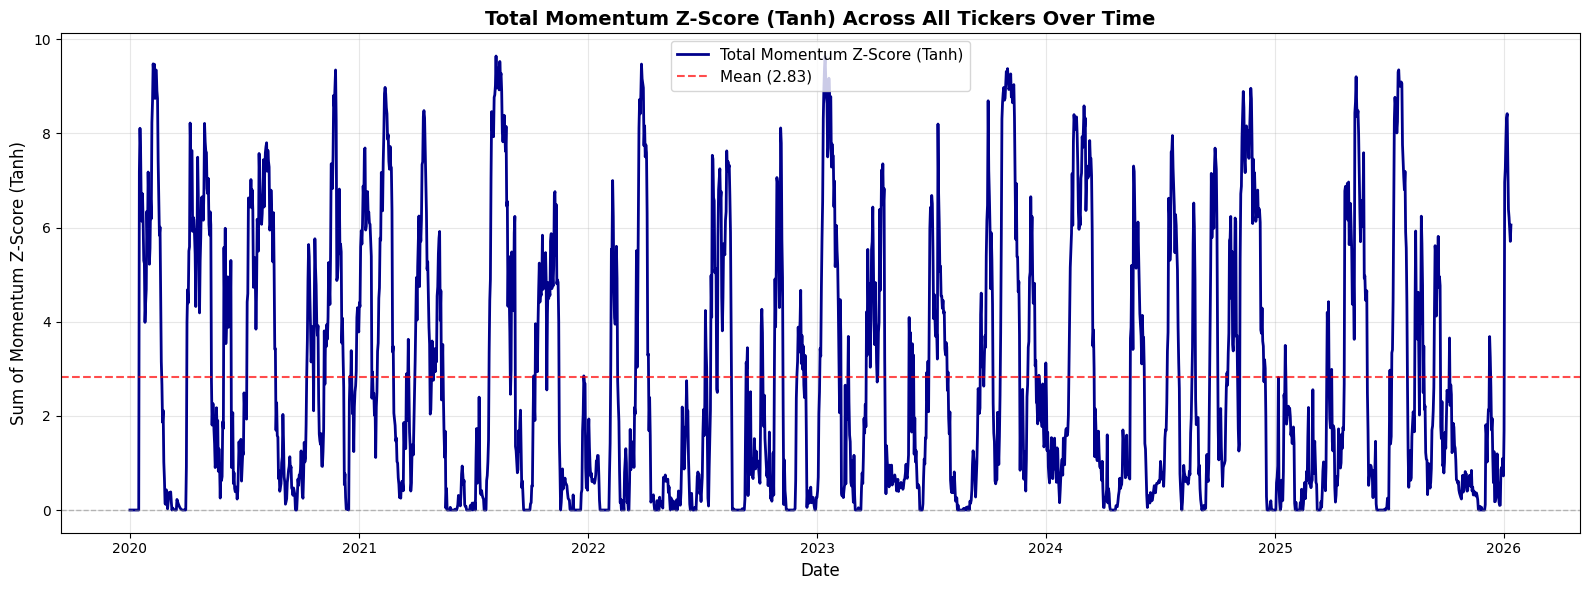

In [6]:
# Exposure over time (for visualization)

# Sum momentum_zscore_tanh values across all tickers over time
total_exposure = combined_signal.clip(lower=0).sum(axis=1)

# Create line plot
plt.figure(figsize=(16, 6))
plt.plot(total_exposure.index, total_exposure, 
         linewidth=2, color='darkblue', label='Total Momentum Z-Score (Tanh)')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
plt.axhline(y=total_exposure.mean(), color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Mean ({total_exposure.mean():.2f})')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sum of Momentum Z-Score (Tanh)', fontsize=12)
plt.title('Total Momentum Z-Score (Tanh) Across All Tickers Over Time', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# Backtest

# Initialize DataFrames to store returns
all_returns = pd.DataFrame()
all_returns_benchmark = pd.DataFrame()

# Iterate through each ticker
for ticker in TICKERS:
    # Prepare data for this ticker
    df_signal = pd.DataFrame({
        'next_day_returns': next_day_returns[('NextDayReturns', ticker)],
        'signal': combined_signal[('CombinedSignal', ticker)]
    }).dropna()
    
    # Strategy: Long-only positions (only when signal > 0)
    df_signal['positions'] = (
        df_signal['next_day_returns'] * 
        df_signal['signal'].clip(lower=0)
    )
    
    # Store strategy returns
    all_returns[ticker] = df_signal['positions']
    
    # Store benchmark returns (buy-and-hold scaled by mean positive signal)
    benchmark_signal = combined_signal[('CombinedSignal', ticker)].clip(lower=0).mean()
    all_returns_benchmark[ticker] = df_signal['next_day_returns'] * benchmark_signal

In [8]:
# Performance Metrics

def calculate_and_display_metrics(portfolio_returns, cumulative_returns, label="Strategy"):
    """Calculate and display performance metrics for a returns series."""
    total_return = (cumulative_returns.iloc[-1] - 1) * 100
    num_days = len(portfolio_returns)
    num_years = num_days / 365
    annualized_return = (cumulative_returns.iloc[-1] ** (365 / num_days) - 1) * 100
    annualized_volatility = portfolio_returns.std() * np.sqrt(365) * 100
    sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(365)
    
    # Calculate maximum drawdown
    cumulative = (1 + portfolio_returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min() * 100
    
    # Display results
    print("=" * 60)
    print(f"BACKTEST RESULTS ({label})")
    print("=" * 60)
    print("Strategy: Momentum")
    print(f"Period: {portfolio_returns.index[0].strftime('%Y-%m')} to {portfolio_returns.index[-1].strftime('%Y-%m')}")
    print(f"Number of years: {num_years:.2f}")
    print("-" * 60)
    print(f"Total Return: {total_return:.2f}%")
    print(f"Annualized Return: {annualized_return:.2f}%")
    print(f"Annualized Volatility: {annualized_volatility:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print("=" * 60)
    
    return {
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'drawdown': drawdown
    }

# Calculate portfolio returns
portfolio_returns = all_returns.mean(axis=1)
portfolio_returns_benchmark = all_returns_benchmark.mean(axis=1)

# Calculate cumulative returns
cumulative_portfolio_returns = (1 + portfolio_returns).cumprod()
cumulative_portfolio_returns_benchmark = (1 + portfolio_returns_benchmark).cumprod()

# Display strategy metrics
metrics = calculate_and_display_metrics(portfolio_returns, cumulative_portfolio_returns, "Strategy")
annualized_return = metrics['annualized_return']
annualized_volatility = metrics['annualized_volatility']
sharpe_ratio = metrics['sharpe_ratio']
max_drawdown = metrics['max_drawdown']
drawdown = metrics['drawdown']

print("\n")

# Display benchmark metrics
_ = calculate_and_display_metrics(portfolio_returns_benchmark, cumulative_portfolio_returns_benchmark, "Benchmark")

BACKTEST RESULTS (Strategy)
Strategy: Momentum
Period: 2020-01 to 2026-01
Number of years: 5.99
------------------------------------------------------------
Total Return: 1508.51%
Annualized Return: 58.95%
Annualized Volatility: 28.14%
Sharpe Ratio: 1.788
Maximum Drawdown: -26.82%


BACKTEST RESULTS (Benchmark)
Strategy: Momentum
Period: 2020-01 to 2026-01
Number of years: 5.99
------------------------------------------------------------
Total Return: 393.65%
Annualized Return: 30.52%
Annualized Volatility: 21.98%
Sharpe Ratio: 1.322
Maximum Drawdown: -29.54%


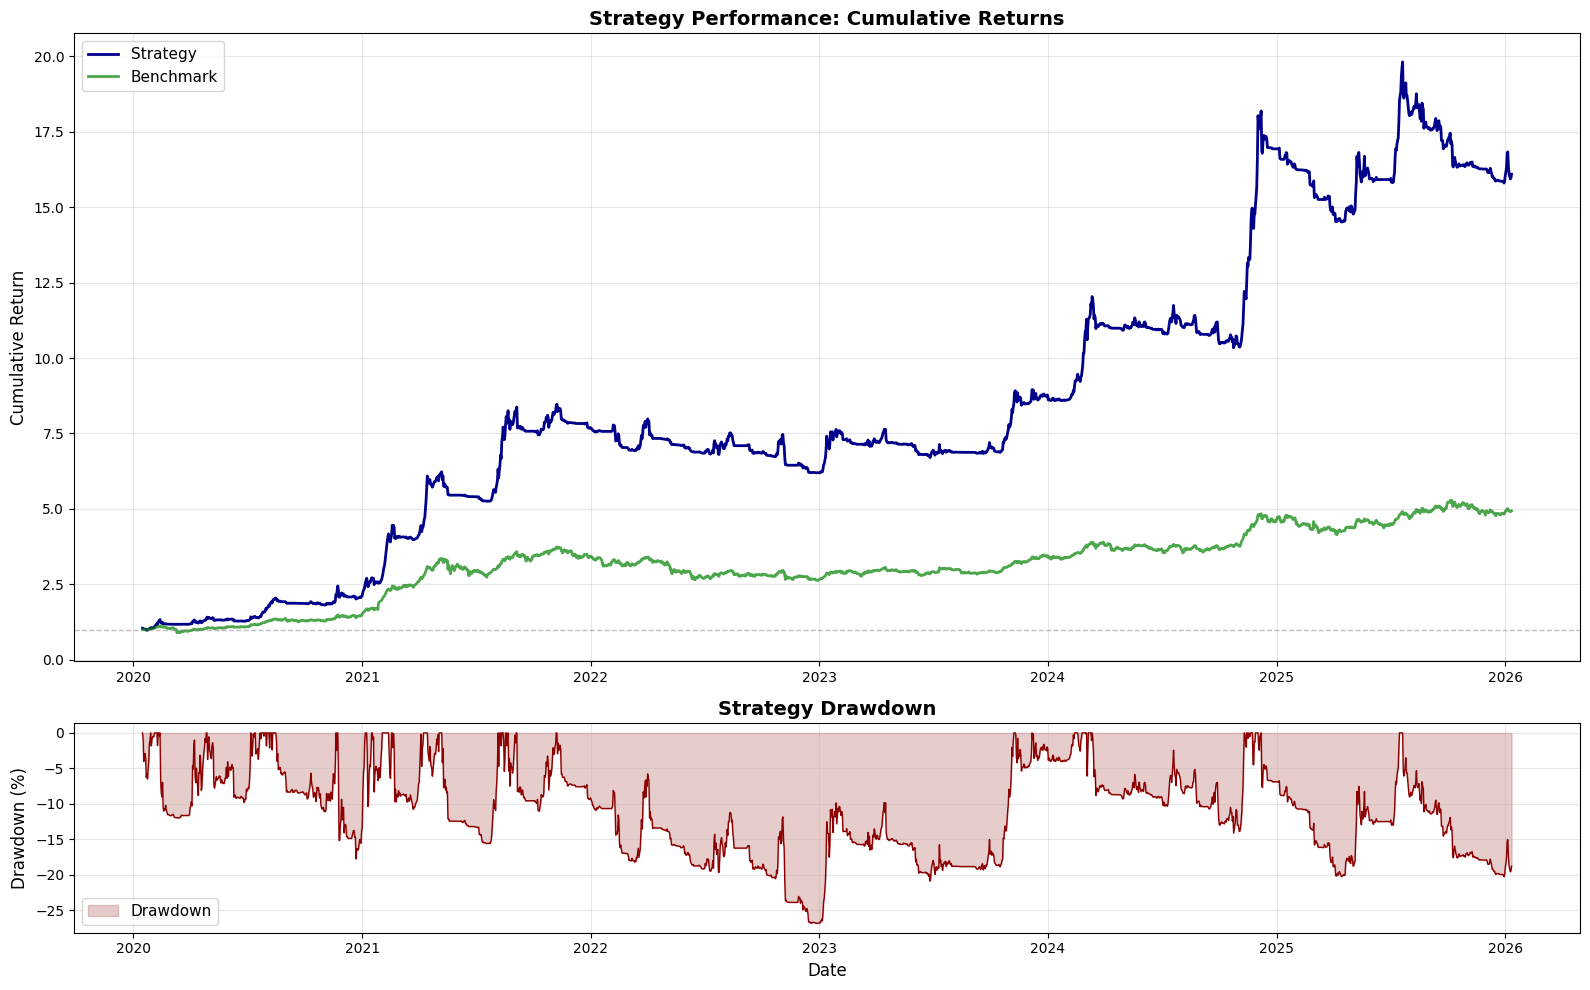

In [9]:
# Visualization

# Create strategy performance and drawdown plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [3, 1]})

# Plot 1: Cumulative Returns (Equity Curve)
ax1.plot(cumulative_portfolio_returns.index, cumulative_portfolio_returns, 
         linewidth=2, label='Strategy', color='darkblue')
ax1.plot(cumulative_portfolio_returns_benchmark.index, cumulative_portfolio_returns_benchmark, 
         linewidth=2, label='Benchmark', color='green', alpha=0.7)

ax1.set_ylabel('Cumulative Return', fontsize=12)
ax1.set_title('Strategy Performance: Cumulative Returns', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Plot 2: Drawdown
ax2.fill_between(drawdown.index, drawdown * 100, 0, 
                 color='darkred', alpha=0.2, label='Drawdown')
ax2.plot(drawdown.index, drawdown * 100, 
         linewidth=1, color='darkred')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Drawdown (%)', fontsize=12)
ax2.set_title('Strategy Drawdown', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='lower left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()

plt.show()

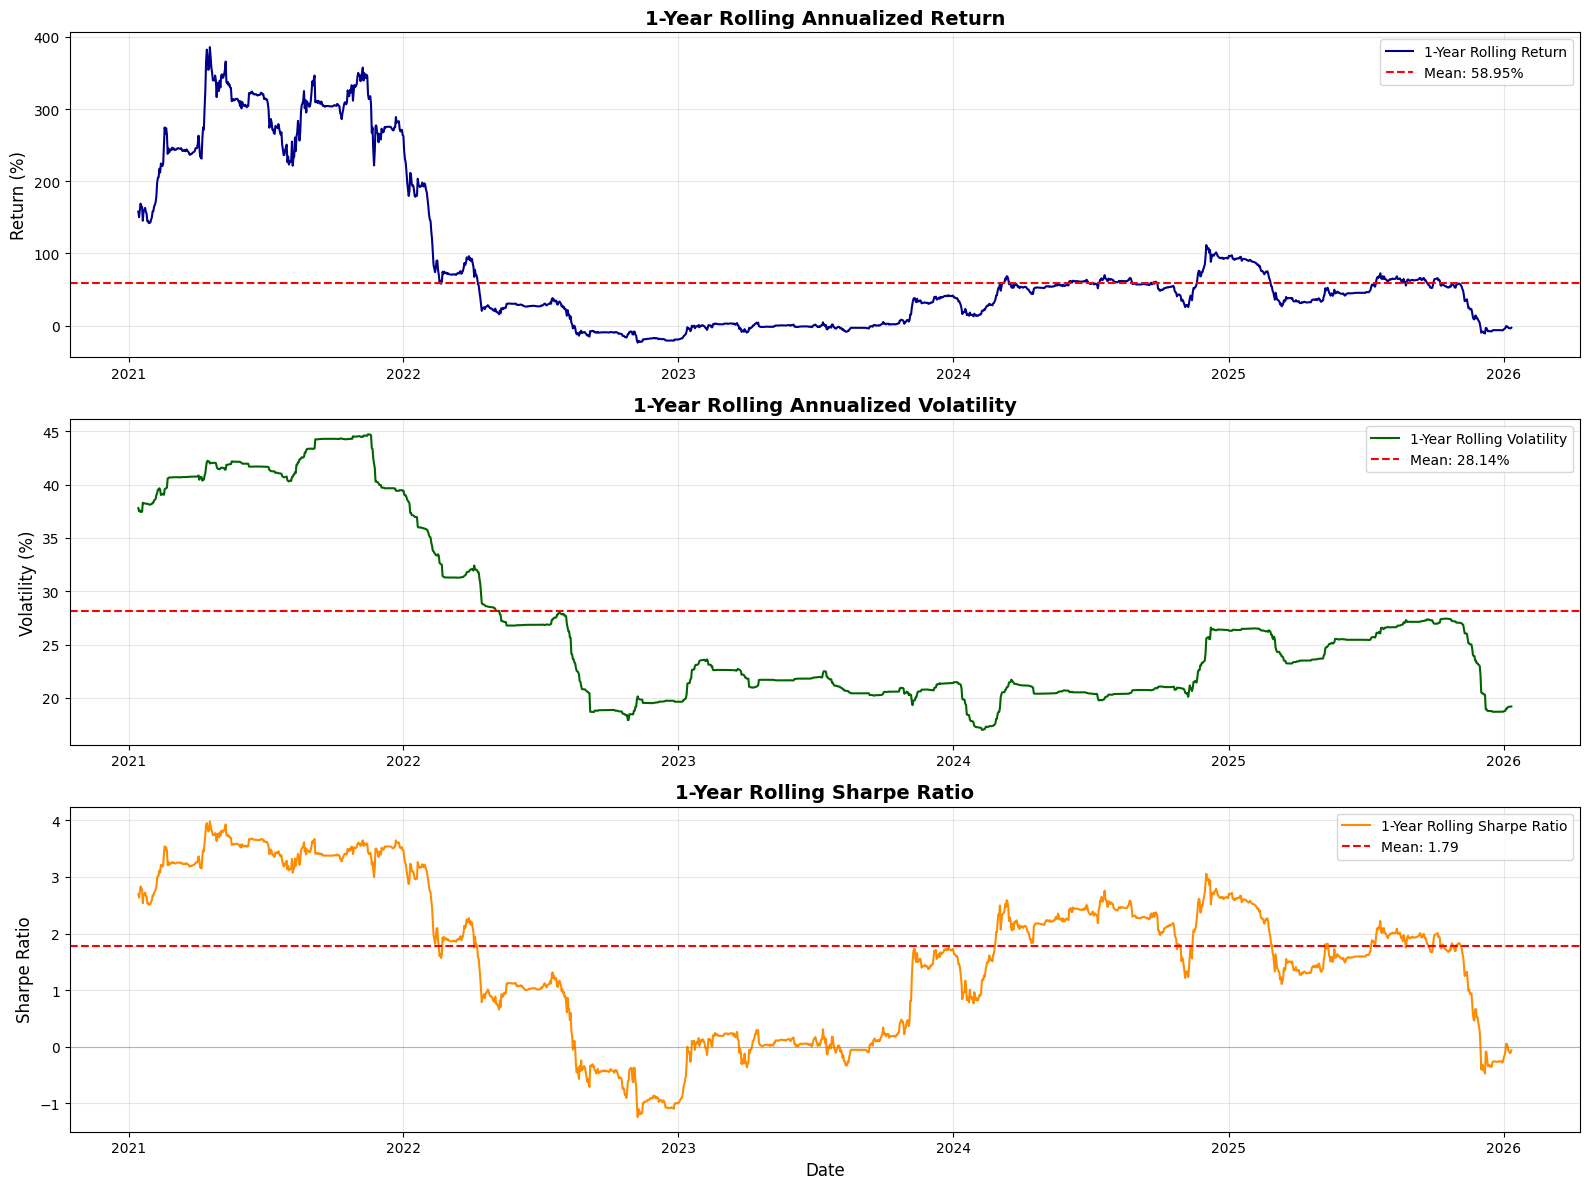

In [10]:
# Rolling Metrics Visualization

# Calculate 1-year rolling metrics for the strategy
rolling_window = 365  # 365 days = 1 year (crypto markets trade daily)

# 1-year rolling return (annualized)
rolling_return = portfolio_returns.rolling(window=rolling_window).apply(
    lambda x: (1 + x).prod() - 1
)

# 1-year rolling volatility (annualized)
rolling_vol = portfolio_returns.rolling(window=rolling_window).std() * np.sqrt(365)

# 1-year rolling Sharpe ratio
rolling_sharpe = (portfolio_returns.rolling(window=rolling_window).mean() / 
                  portfolio_returns.rolling(window=rolling_window).std()) * np.sqrt(365)

# Create the plots
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Plot 1: Rolling Return
ax1 = axes[0]
ax1.plot(rolling_return.index, rolling_return * 100, 
         linewidth=1.5, color='darkblue', label='1-Year Rolling Return')
ax1.axhline(y=annualized_return, color='red', linestyle='--', linewidth=1.5, 
            label=f'Mean: {annualized_return:.2f}%')
ax1.set_ylabel('Return (%)', fontsize=12)
ax1.set_title('1-Year Rolling Annualized Return', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Rolling Volatility
ax2 = axes[1]
ax2.plot(rolling_vol.index, rolling_vol * 100, 
         linewidth=1.5, color='darkgreen', label='1-Year Rolling Volatility')
ax2.axhline(y=annualized_volatility, color='red', linestyle='--', linewidth=1.5, 
            label=f'Mean: {annualized_volatility:.2f}%')
ax2.set_ylabel('Volatility (%)', fontsize=12)
ax2.set_title('1-Year Rolling Annualized Volatility', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Rolling Sharpe Ratio
ax3 = axes[2]
ax3.plot(rolling_sharpe.index, rolling_sharpe, 
         linewidth=1.5, color='darkorange', label='1-Year Rolling Sharpe Ratio')
ax3.axhline(y=sharpe_ratio, color='red', linestyle='--', linewidth=1.5, 
            label=f'Mean: {sharpe_ratio:.2f}')
ax3.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
ax3.set_xlabel('Date', fontsize=12)
ax3.set_ylabel('Sharpe Ratio', fontsize=12)
ax3.set_title('1-Year Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()